#Mounting & Importing Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras import layers
#from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout,GlobalAveragePooling2D
from tensorflow.keras import Sequential
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation,RandomFlip,Rescaling
from tensorflow.keras.callbacks import EarlyStopping
import shutil
from tensorflow.keras.models import load_model, Model, Sequential
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from matplotlib import pyplot as plt
from keras import applications

In [3]:
!pip install -q --upgrade wandb
import wandb
from wandb.keras import WandbCallback
wandb.login()

     |████████████████████████████████| 1.7 MB 5.3 MB/s 
     |████████████████████████████████| 180 kB 49.4 MB/s 
     |████████████████████████████████| 97 kB 6.1 MB/s 
     |████████████████████████████████| 133 kB 49.9 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./03. Utils')
import MyFunctions

#The Model

https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33
https://github.com/priya-dwivedi/Deep-Learning/tree/master/resnet_keras

In [5]:
IMAGE_SIZE = (128,128)
NUM_CLASSES = 3 
BATCH_SIZE = 32 

In [6]:
df_train=pd.read_excel("/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/train0-7.xlsx")
df_test=pd.read_excel("/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/test0-7.xlsx")

In [7]:
train_datagen = ImageDataGenerator(validation_split = 0.2,rescale = 1./255)
dir = '/content/drive/My Drive/Quinto_Anio/TESIS_Eugenia_Berrino/DS_comp_nodef'
train_batches = train_datagen.flow_from_dataframe( #tomamos info de un df
    df_train, 
    directory=dir,
    x_col='ImageID',y_col='Projection',
    target_size=IMAGE_SIZE,
    shuffle=True,
    batch_size=BATCH_SIZE,
    subset = "training",
    seed=42,
    class_mode="categorical",)

Found 13951 validated image filenames belonging to 3 classes.


In [8]:
valid_batches = train_datagen.flow_from_dataframe(df_train, directory=dir,
                                            x_col='ImageID',y_col='Projection',
                                            target_size=IMAGE_SIZE,
                                            shuffle=True,
                                            batch_size=BATCH_SIZE,
                                            subset = "validation",
                                            seed=42,
                                            class_mode="categorical",)

Found 3487 validated image filenames belonging to 3 classes.


In [9]:
from tensorflow.keras.applications import resnet50
base_model = resnet50.ResNet50(weights= 'imagenet', include_top=False, input_shape= (IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
base_model.trainable = False 
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten()) 
model.add(layers.Dense(256, activation="relu")) 
model.add(layers.Dense(NUM_CLASSES, activation="softmax")) 
x = model.output

94781440/94765736 [==============================] - 1s 0us/step


In [10]:
from tensorflow.keras.optimizers import Adam
adam = Adam(learning_rate=0.0001)
model.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               8388864   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771       
Total params: 31,977,347
Trainable params: 8,389,635
Non-trainable params: 23,587,712
_________________________________________________________________


In [12]:
# Initialize wandb with your project name
run = wandb.init(project='filter',
                 config={  # and include hyperparameters and metadata
                     "learning_rate": 0.0001,
                     "epochs": 100,
                     "batch_size": 32,
                     "Transfer Learning":"Si",
                     "loss_function": "categorical_crossentropy",
                     "architecture": "ResNet 50",
                     "dataset": "PA-AP-L"
                 })
config = wandb.config

wandb: Currently logged in as: eberrino (use `wandb login --relogin` to force relogin)


In [13]:
history = model.fit(train_batches, validation_data = valid_batches , epochs = 100,workers=10,
                    callbacks=[EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True),WandbCallback()], batch_size = BATCH_SIZE)

Epoch 1/100
436/436 [==============================] - 507s 1s/step - loss: 0.4439 - accuracy: 0.8698 - val_loss: 0.2551 - val_accuracy: 0.9378


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
436/436 [==============================] - 123s 279ms/step - loss: 0.2117 - accuracy: 0.9430 - val_loss: 0.1682 - val_accuracy: 0.9478
Epoch 3/100
436/436 [==============================] - 114s 258ms/step - loss: 0.1584 - accuracy: 0.9555 - val_loss: 0.1308 - val_accuracy: 0.9596
Epoch 4/100
436/436 [==============================] - 112s 252ms/step - loss: 0.1384 - accuracy: 0.9609 - val_loss: 0.1170 - val_accuracy: 0.9710
Epoch 5/100
436/436 [==============================] - 110s 249ms/step - loss: 0.1227 - accuracy: 0.9655 - val_loss: 0.1141 - val_accuracy: 0.9725
Epoch 6/100
436/436 [==============================] - 112s 253ms/step - loss: 0.1145 - accuracy: 0.9693 - val_loss: 0.0923 - val_accuracy: 0.9759
Epoch 7/100
436/436 [==============================] - 114s 258ms/step - loss: 0.1065 - accuracy: 0.9715 - val_loss: 0.1012 - val_accuracy: 0.9733
Epoch 8/100
436/436 [==============================] - 110s 249ms/step - loss: 0.0974 - accuracy: 0.9753 - val_loss: 0

In [14]:
model.save('/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./04. Weights/Exp 2: Mejoras a la Clasificaciónde proyecciones/ResNet_TL.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


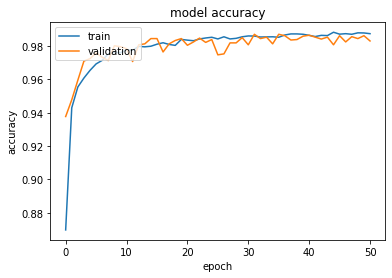

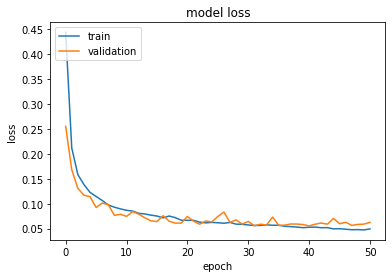

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [16]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_batches = test_datagen.flow_from_dataframe(
    df_test, 
    directory=dir,
    x_col='ImageID',y_col='Projection',
    target_size=IMAGE_SIZE,
    shuffle=False,
    batch_size=1,
    seed=42,
    class_mode="categorical"#, validate_filenames=False
    )

Found 4360 validated image filenames belonging to 3 classes.


In [ ]:
model = load_model('/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./04. Weights/Exp 2: Mejoras a la Clasificaciónde proyecciones/ResNet_TL.h5')

In [17]:
#Calculamos la matriz de predicciones
result_test=model.predict(test_batches, verbose=1)
print(result_test.shape)

4360/4360 [==============================] - 1054s 241ms/step
(4360, 3)


In [ ]:
#Calculamos la matriz de predicciones
#result_test=model.predict(test_batches, verbose=1)
print ("Loss = " + str(result_test[0]))
print ("Test Accuracy = " + str(result_test[1]))

Loss = [0.0024932  0.00563455 0.99187225]
Test Accuracy = [3.4253206e-12 6.0411563e-15 1.0000000e+00]


In [18]:
#Obtenemos el nombre de clase asociado a cada indice
classes_dict = dict(zip(train_batches.class_indices.values(),train_batches.class_indices.keys()))
classes_dict

{0: 'AP_horizontal', 1: 'L', 2: 'PA'}

In [25]:
import os 
os.chdir('/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./03. Utils/')
import MyFunctions

In [26]:
preds_classes, gts = MyFunctions.after_test(classes_dict,result_test,test_batches)

PA               2724
L                1442
AP_horizontal     194
dtype: int64
               precision    recall  f1-score   support

AP_horizontal       0.95      0.85      0.90       217
            L       0.99      1.00      0.99      1427
           PA       0.99      0.99      0.99      2716

     accuracy                           0.99      4360
    macro avg       0.97      0.95      0.96      4360
 weighted avg       0.99      0.99      0.99      4360



In [19]:
#Obtenemos el índice de mayor score en cada fila (cada imagen)
preds = result_test.argmax(axis=-1)

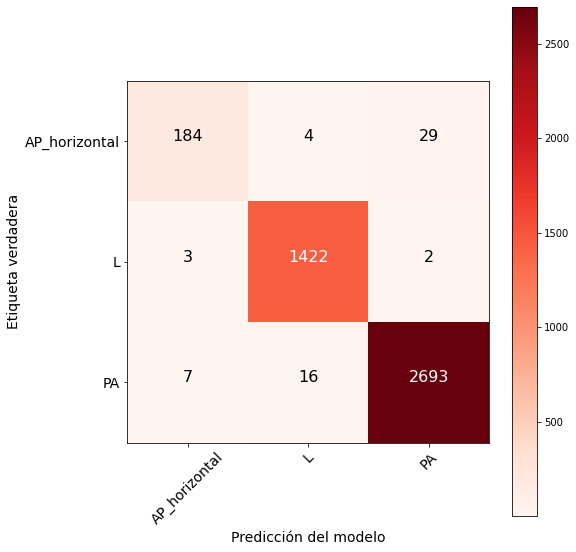

In [29]:
MyFunctions.plot_confusion_matrix(gts,preds_classes,test_batches.class_indices.keys(),
                                  path='/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./01. Filtrado/03. Exp 2: Mejoras a la Clasificación de Proyecciones/02. ResNet-50/Results/TL/Images/CM')

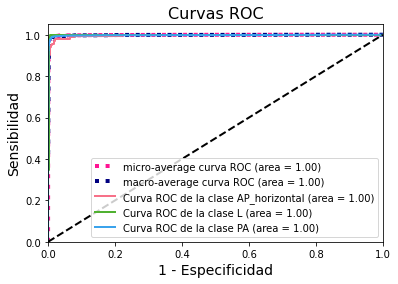

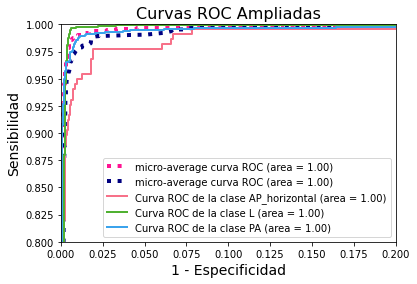

In [30]:
MyFunctions.plot_ROC(result_test,gts,NUM_CLASSES, classes_dict,
                     path='/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./01. Filtrado/03. Exp 2: Mejoras a la Clasificación de Proyecciones/02. ResNet-50/Results/TL/Images/ROC_Filtro_Unico')

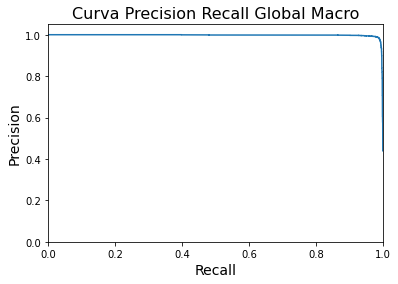

In [31]:
MyFunctions.precision_recall_global(result_test,gts,NUM_CLASSES,
                     path='/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./01. Filtrado/03. Exp 2: Mejoras a la Clasificación de Proyecciones/02. ResNet-50/Results/TL/Images/PRG_Filtro_Unico')

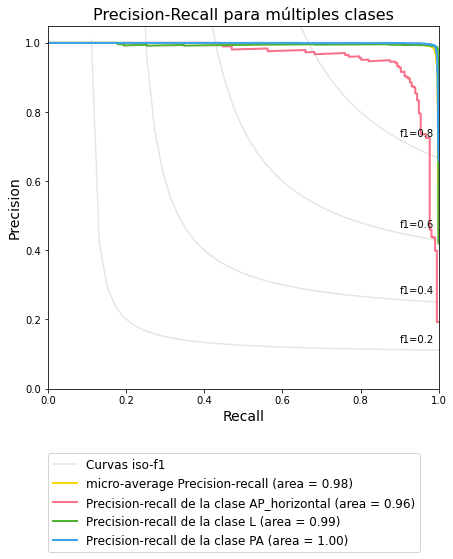

In [32]:
MyFunctions.precision_recall_many(result_test,gts,NUM_CLASSES, classes_dict,
                                  path='/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./01. Filtrado/03. Exp 2: Mejoras a la Clasificación de Proyecciones/02. ResNet-50/Results/TL/Images/PRM_Filtro_Unico')

In [33]:
pd.DataFrame(result_test).to_csv('/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./01. Filtrado/03. Exp 2: Mejoras a la Clasificación de Proyecciones/02. ResNet-50/Results/TL/result_test_crude.csv')

In [34]:
df_test["Pred"] = preds_classes

In [35]:
df_test["result"] = df_test["Projection"]==df_test["Pred"]
df_test.head()

,Unnamed: 0,ImageID,ImageDir,Projection,Pred,result
0,0,5/117461681536540587607592076584888612953_wmoy...,5,PA,PA,True
1,1,0/214260817085057432303623958907855926368_jrl2...,0,PA,PA,True
2,2,4/144306045728819370188471558682816175107_vhmd...,4,PA,PA,True
3,3,1/213096160366986458367121958911602047465_wble...,1,PA,PA,True
4,4,4/280022667207150747197673782766436308679_15wi...,4,PA,PA,True


In [36]:
df_test.to_csv('/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./01. Filtrado/03. Exp 2: Mejoras a la Clasificación de Proyecciones/02. ResNet-50/Results/TL/result_test_final.csv')